# Estimating Preciptation in Alaska Using Surface Regression (12 points)


## Introduction

In this part of the project, your goal is to perform a 3D surface regression which will fit a model that will allow us to estimate the total amount of precipitation during the month of July 2020 at any longitude/latitude pair that falls in the state of Alaska.

Our estimation will be based off of datasets maintained by the National Oceanic and Atmospheric Administration (NOAA) which provides free access to a variety of weather and climate datasets. You can access the full dataset that we use here: https://data.nodc.noaa.gov/cgi-bin/iso?id=gov.noaa.ncdc:C00332. 

When performing any kind of data analysis one, of the first steps is to get a feel for the data. That can mean many things from understanding the size of the dataset, peeking at what the data looks like (does it contain string values, integers, floats) and exploring if there is missing data, to name just a few aspects of interest. 

### The first set of cells start off by reading in our dataset and visualizing the information.

__Dataset Citation__ : Vose, Russell S., Applequist, Scott, Squires, Mike, Durre, Imke, Menne, Matthew J., Williams, Claude N. Jr., Fenimore, Chris, Gleason, Karin, and Arndt, Derek (2014): Gridded 5km GHCN-Daily Temperature and Precipitation Dataset (nCLIMGRID), Version 1. 202007.prcp.alaska.pnt. NOAA National Centers for Environmental Information. DOI:10.7289/V5SX6B56 Aug 1, 2020.

In [1]:
using Plots, LaTeXStrings, LinearAlgebra, CSV, ProgressBars, Printf, Random, DataFrames

# We use import here because the GMT package also has a plot function
# that would override the plot function made available with the Plots
# package. Thus any function in the GMT package needs to be called
# GMT.function_name(...)
import GMT

# Set the plotting backend to gr
gr()

Plots.GRBackend()

In [2]:
# Run me, don't change me. I will download the dataset
# to IllumiDesk and also display the size and first 
# five rows of the data. 

df = CSV.read( "202007_prcp_alaska.csv", DataFrame, header=false)
data = Matrix(df)

@show typeof(data);
@show size(data);

# Print out the first five rows
data[1:5,:]

typeof(data) = Matrix{Float64}
size(data) = (27861, 3)


5×3 Matrix{Float64}:
 -153.498  67.21    59.9
 -159.866  65.6886  32.75
 -164.678  65.8171  16.48
 -159.159  70.5409  21.21
 -156.492  64.0326  59.61

## The dataset we have just read in contains 3 columns. The first column contains longitude values which range from -180 to 0 (western hemisphere) or 0 to 180 (eastern hemisphere). The second column contains latitude values which we can think of as horizontal slices across the world. Latitude values can range from 0 to 90 (northern hemisphere) or -90 to 0 (southern hemisphere).  The third and final column contains total precipitation information in millimeters.

### Note:  300 mm = 30 cm = 1 foot of rain


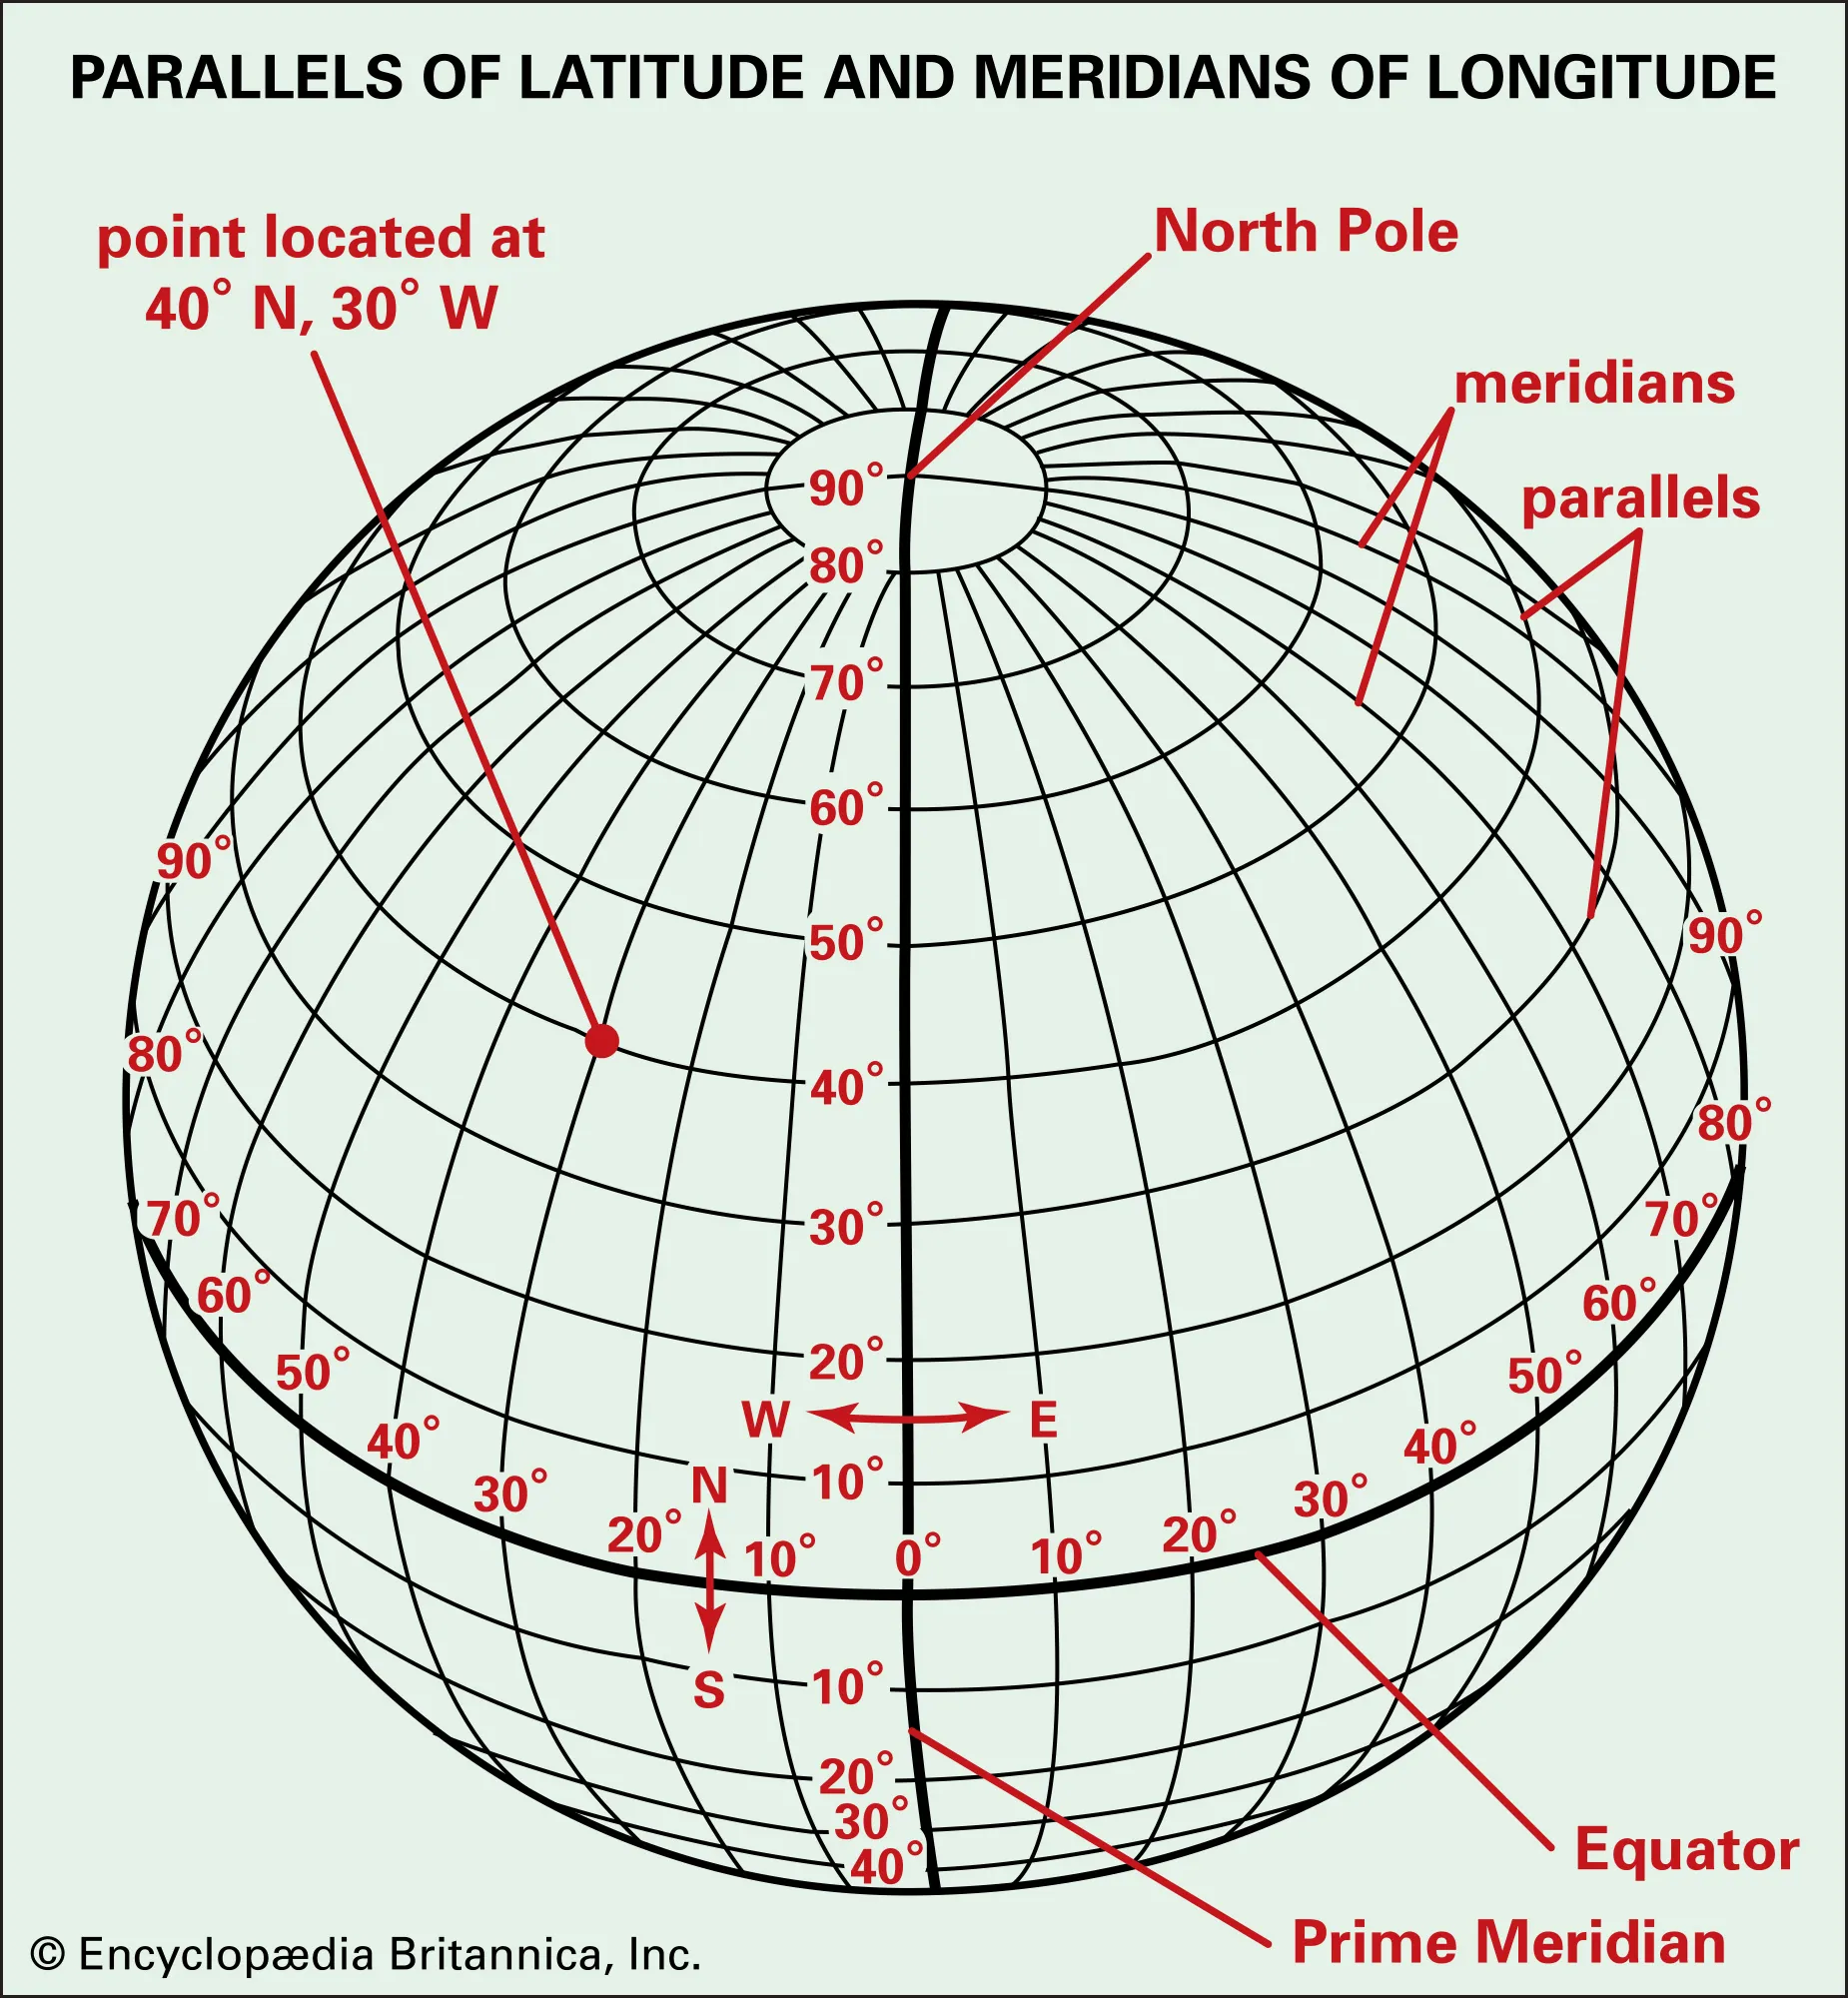

**Image from https://www.britannica.com/science/latitude**

In [3]:
# Run me, don't change me
# Split the data into geometric coordinates and precipitation values
# You will use these later in this notebook
dataLongLat=data[:,1:2]
dataPrecip=data[:,3]
@show size(dataLongLat) 
@show length(dataPrecip) 

size(dataLongLat) = (27861, 2)
length(dataPrecip) = 27861


27861

### This is SUPER IMPORTANT as you progress in the notebook. What is the difference between the `length` command and the `size` command?

In [4]:
A=randn(20,30)
@show nRows,nCols = size(A)
@show nRows = size(A, 1)
@show nCols = size(A, 2)
@show length(A)
println("You must notice that length of a matrix is the PRODUCT nRows*nCols, which is its total number of entries")
println("In the following, you NEVER EVER EVER want to apply `length` to a matrix. Only apply it to vectors.")

(nRows, nCols) = size(A) = (20, 30)
nRows = size(A, 1) = 20
nCols = size(A, 2) = 30
length(A) = 600
You must notice that length of a matrix is the PRODUCT nRows*nCols, which is its total number of entries
In the following, you NEVER EVER EVER want to apply `length` to a matrix. Only apply it to vectors.


### You must notice that length of a matrix is the PRODUCT nRows*nCols, which is its total number of entries
### In the following, you NEVER EVER EVER want to apply length to a matrix. Only apply it to vectors.

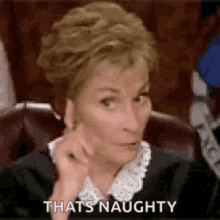
Judge Judy!

## This being a larger dataset, let's create a scatter plot using the location of a small portion of the samples to further get a sense of the dataset and the values within it. We will use the provided sample function to do this.

In [5]:
# Run me, don't change me. I am a function that returns 
# a portion of the dataset based on the percentage provided

#=
Samples a percentage of the rows of matrix 'data'

Input:
    data    - data matrix to sample rows from
    percent - 0 < percent <= 100
=#
function sample_rows(data, percent)
   
    @assert percent > 0 && percent <= 100
    
    rows = size(data, 1)
    
    # Set's the initial condition of the random number generator
    # so that every notebook will arrive at the same results
    Random.seed!(1817);
    
    select = Int(div(rows, 100 / percent , RoundUp))
    indices = Int.(unique(ceil.(rand(select) * rows))) # random indicies
    
    col1 = data[indices, 1]
    col2 = data[indices, 2]
    prcp = data[indices, 3]
    
    # Assemble columns using horizontal concatenation
    # concatenation in this case means placing side by side
    subset = hcat(col1, col2, prcp)

    return subset
end

sample_rows (generic function with 1 method)

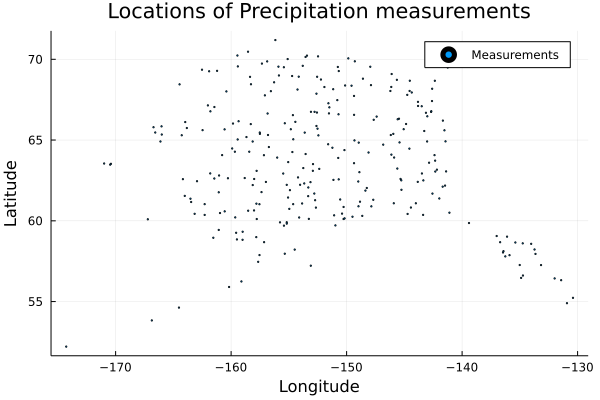

In [6]:
# Run me, don't change me! I sample and display the locations
# of 1% of the measurements in our dataset
percent = 1 

dataSubset = sample_rows(data, percent)
centers = dataSubset[:,1:2] # We only want the geometric data for the centers

s1 = scatter(
    centers[:,1], 
    centers[:,2], 
    markersize=1,
    label="Measurements",
    xlabel="Longitude",
    ylabel="Latitude",
    title="Locations of Precipitation measurements"
)

## After running the scatter function, you should be able to see the shape of Alaska take form. Each (x,y) point corresponds to a (longitude, latitude) pair in the dataset. 

Another view of the data would be to visualize the precipitation value at each point. We make use of the GMT package's bar3 function to create a 3D plot of the precipitation recorded at each location. Before being able to call the function, however, we need to section up Alaska into a series of bins. Imagine placing a checkerboard over the above graph. Each square in the checkerboard will have a (lon,lat) pair associated with it. Each measurement will be placed in the square that it's closest to. We will take an average if there are squares that have more than one measurement associated with it. 

The pixelate function below helps us with taking our data, and turning it into the grid we described. Note, you only need to understand the inputs and outputs to the function, not all of the code. 

In [7]:
# Run me, don't change me!

#=
pixelate(data::AbstractArray, n_xpixels::Int, n_ypixels::Int)

Takes a 3D matrix (lon,lat,rain) and returns a grid where each pixel is 
equal to the average of all the rain measurements that fall into that pixel

Inputs:
    data      - the data set
    n_xpixels - the number of pixels on the x axis (longitude)
    n_ypixels - the number of pixels on the y axis (latitude)

Output:
    grid      - a n_ypixels x n_xpixels matrix holding the average 
                rain that fell in that location
=#
function pixelate(data::AbstractArray, n_xpixels::Int, n_ypixels::Int)

    # (lon,lat) coordinates with measured rain in third column
    @assert size(data, 2) == 3
    
    # No nan values exist in data
    @assert !any(isnan.(data))
    
    xmin = min(data[:,1]...)
    xmax = max(data[:,1]...)
    ymin = min(data[:,2]...)
    ymax = max(data[:,2]...)
    
    xedges = collect(range(floor(xmin), ceil(xmax), length=n_xpixels))
    yedges = collect(range(floor(ymin), ceil(ymax), length=n_ypixels))
    
    grid = zeros(n_ypixels, n_xpixels)
    count = zeros(n_ypixels, n_xpixels)
    
    for i in 1:size(data,1)
        x_idx = searchsortedlast(xedges, data[i,1])
        y_idx = searchsortedlast(yedges, data[i,2])
        
        grid[y_idx, x_idx] += data[i,3]
        count[y_idx, x_idx] += 1
    end
    
    grid = grid./ count
    
    # Replace Nan from divide by 0 with 0
    replace!(grid, NaN=>0)
        
    return GMT.mat2grid(grid, x=xedges, y=yedges)
end

pixelate (generic function with 1 method)

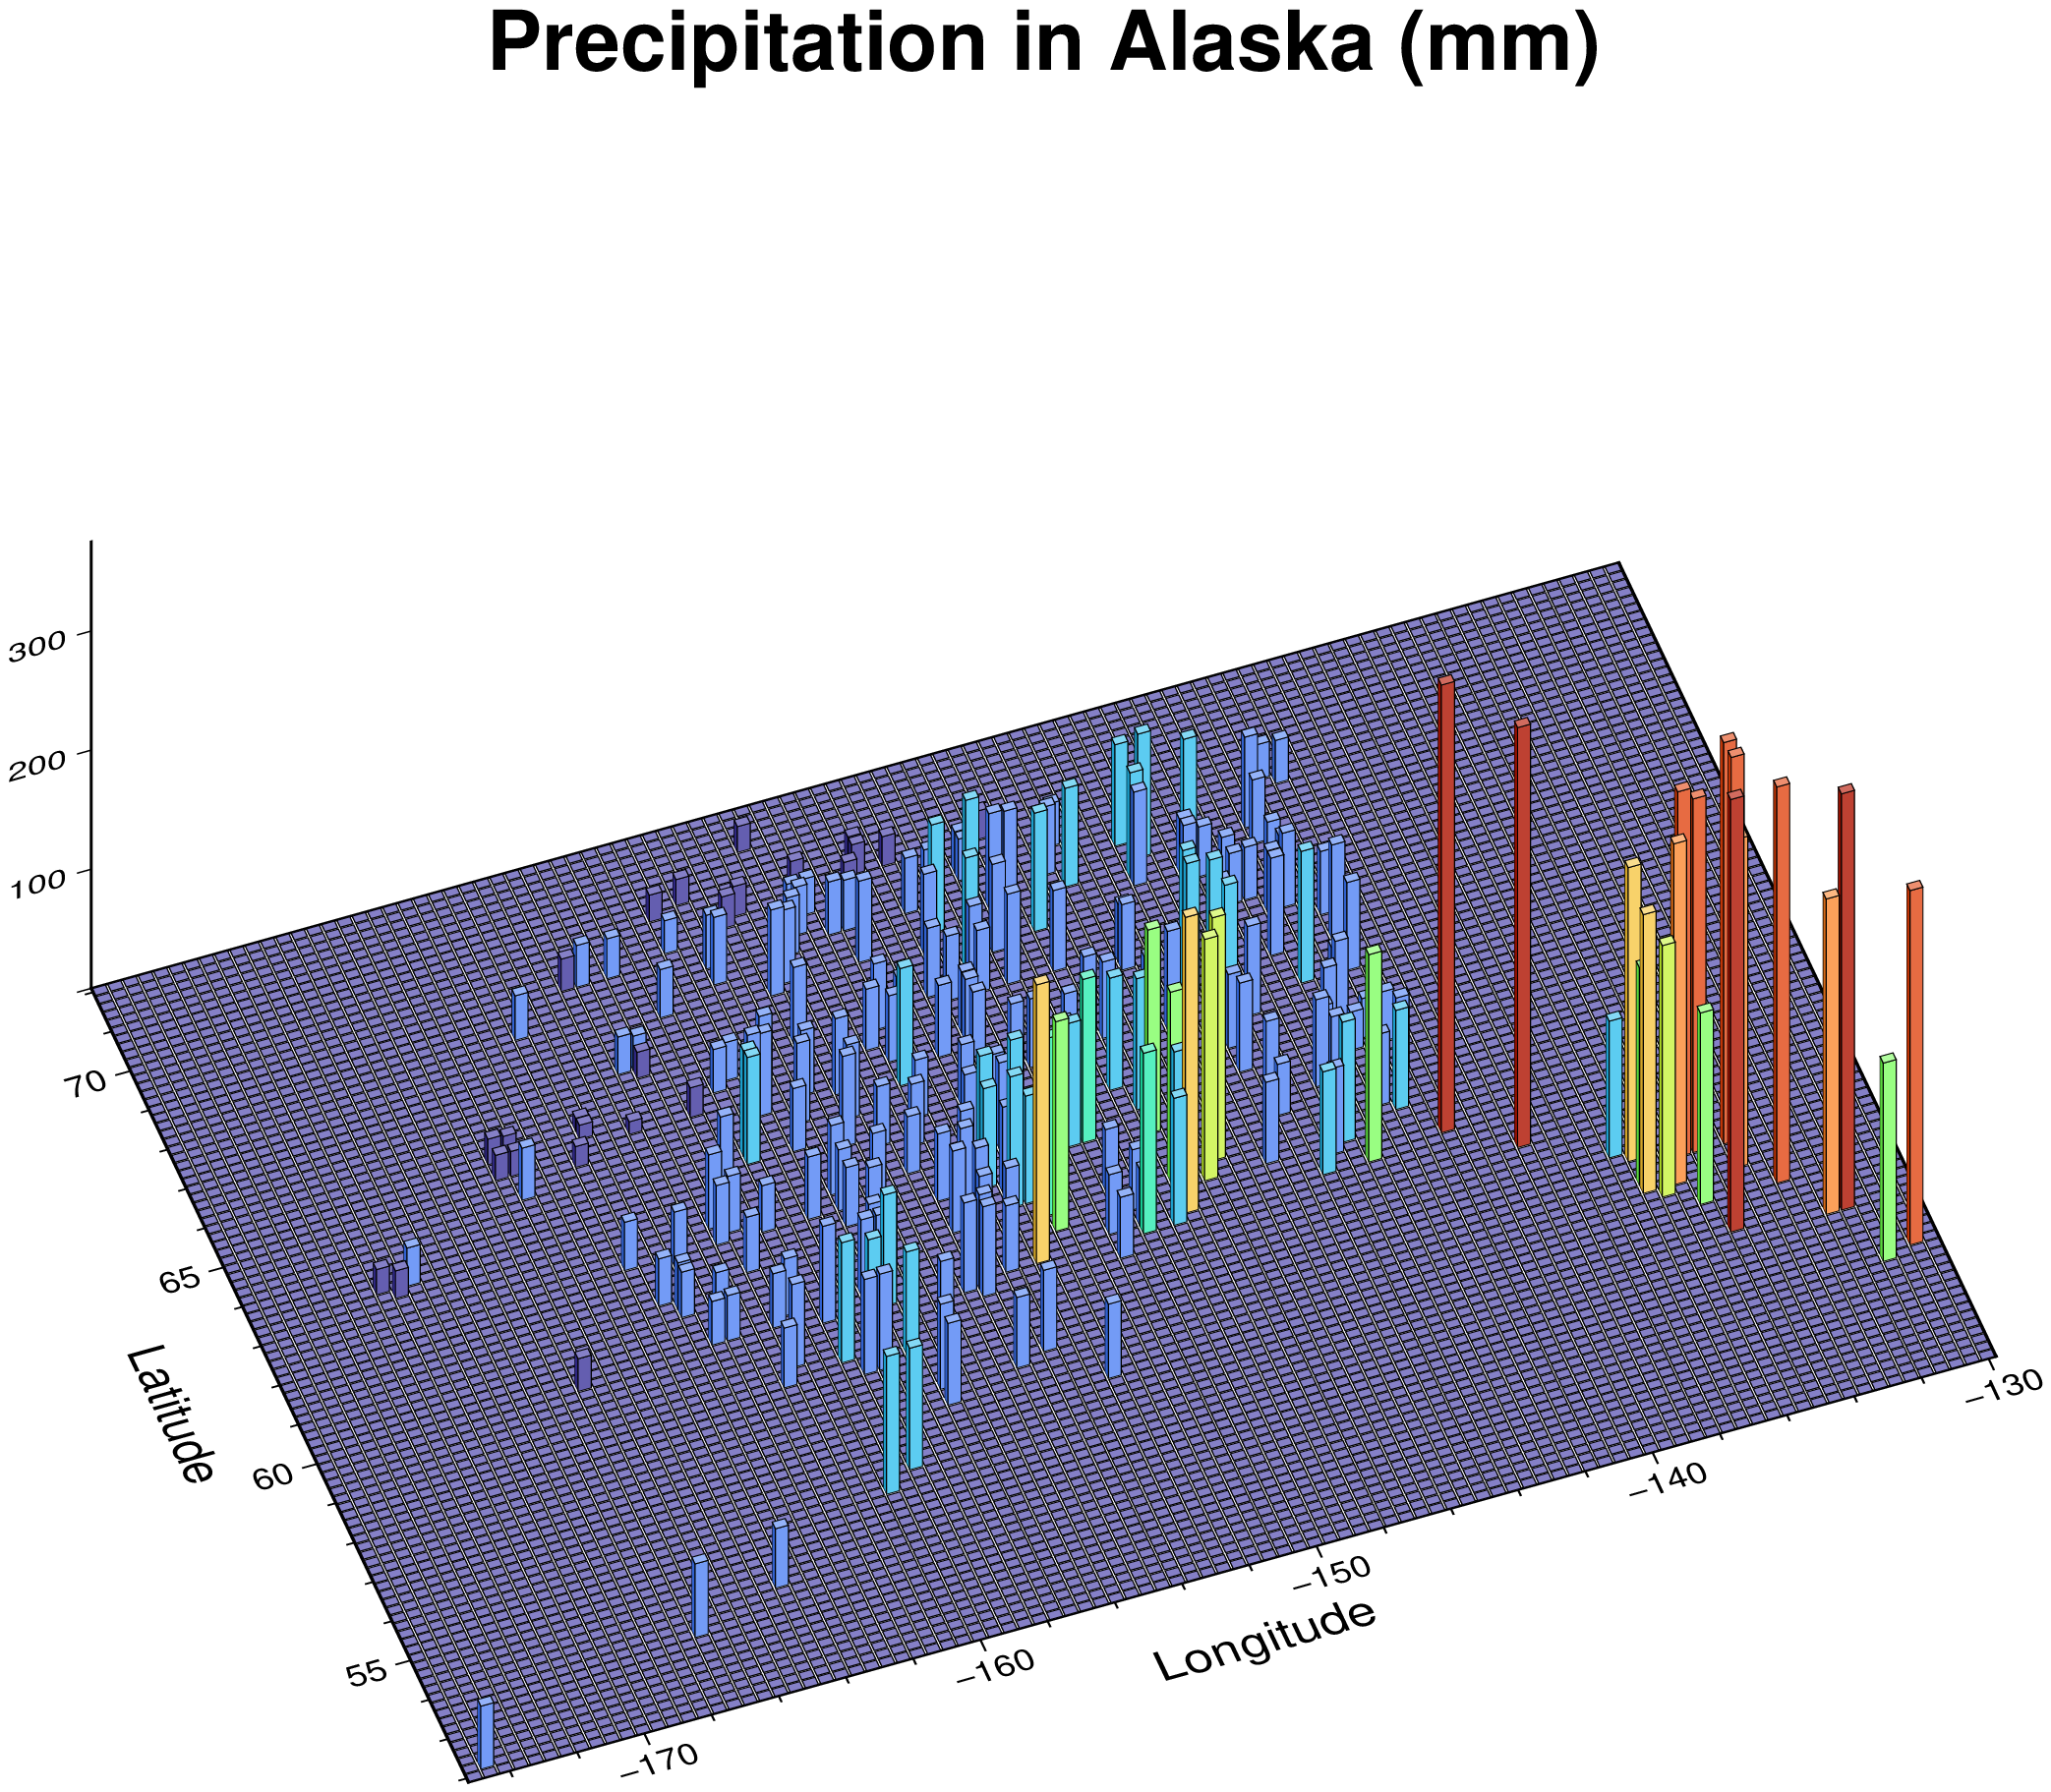

In [8]:
# Run me, don't change me! I create a 3D bar graph that
# displays the precipitation across the state of Alaska

grid = pixelate(dataSubset, 100, 100)
cmap = GMT.grd2cpt(grid);  # Compute a colormap with the grid's data range

# Plotting function to make a 3D bar graph
GMT.bar3(grid, lw=:thinnest, color=cmap, fmt=:png, show=true, view=(200,50),
         xlabel="Longitude", ylabel="Latitude", title="Precipitation in Alaska (mm)")

We see that for most of the state of Alaska, not a lot of precipitation fell. However, near the south of Alaska where the state capitol Juneau resides, there was quite a bit of precipitation that fell relative to the rest of the state in July. And indeed it is quite beautiful there in the summer! 

__Reference__: https://www.weather-us.com/en/alaska-usa/juneau-climate


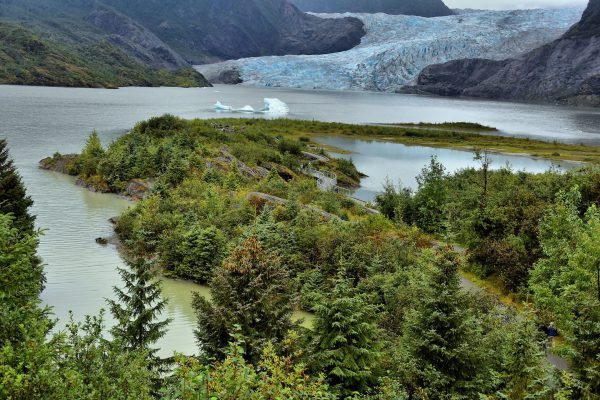

If you try plotting a higher percentage of measurement samples, you may feel that the 3D bar plot is already dense enough. However, note that each degree of difference in latitude/longitude is approximately 50-70 miles apart depending on where you are in the world (closer to the equator or pole etc.) Additionally, we wish to be able to create a model that allows us to estimate the precipitation level at any (longitude, latitude) pair at infinite resolution.

### In the rest of the notebook, you will create a model that will be able to estimate the amount of precipitation that fell during the month of July anywhere in Alaska. To do this, you will perform a surface regression using the radial functions as your basis.

## Task 3: Build a Regression Model to Predict the Precipitation in Alaska (4+3+2+3 points)

### Part A: Modify the Helper Functions (4 points)

Just as in the previous notebook, we will need to build a pipeline for fitting our model. We can take our pipeline and helper functions from our previous notebook almost as is, except for the fact that now our data points (can also be referred to as the'x' values or lon/lat values) will be in $\mathbb{R}^2$. The value being measured, in this case the amount of precipitation, will remain in $\mathbb{R}$. This also means that our basis centers can no longer be determined by a single point. They will also be in $\mathbb{R}^2$. Our RBFs will now look like a hill where $x_c$ positions the hill somewhere in the xy plane, $a_i$ the coefficient determines how tall the hill is and $s$ determines how quickly values evaluated further and further from $x_c$ go to 0 or said another way the incline/gradient/steepness of the hill.


In the cells below, we have brought over 5 functions from the previous notebook:

* ```rbf```
* ```backwardsub```
* ```forwardsub```
* ```calc_phi_row```
* ```regressor_matrix```
* ```least_squres_lu```

Two of the functions ```calc_phi_row``` and ```regressor_matrix``` need to be modified to allow for passing in data that is now in $\mathbb{R}^2$ as we described above. Please identify and make the corresponding modifications.

In [9]:
# Run me, don't change me. I define the RBF.

# Radial basis function
rbf(x, xc, s) = exp.(-norm(x-xc)^2 / (2*s^2))

rbf (generic function with 1 method)

In [10]:
# Run me, don't change me. I will create the LU Pipeline! Wooo Hooo!!!

#=
forwardsub(L, b)

It solves for x in an equation Lx = b, where L is lower triangular.
=#

function forwardsub(L, b)
    # START of our computations
    n = length(b)
    x = Vector{Float64}(undef, n); #initialize an x vector of the correct size
    x[1] = b[1]/L[1,1] #find the first entry of x
    for i = 2:n #find every entry from the 2nd to the end
        x[i]=(b[i]- (L[i,1:i-1])'*x[1:i-1] )/L[i,i] 
        #notice that we used the transpose operator to get the row of L
    end
    # END of our computations. 
    return x
end

#=
backwardsub(U, b)

It solves for x in an equation Ux = b, where U is upper triangular.
=#

function backwardsub(U, b)    
    # Assert no entries in the diagonal of U
    # are 0 (or very close to 0)
    @assert minimum(abs.(diag(U))) > 1e-6
    
    n = length(b)
    x = Vector{Float64}(undef, n)

    x[n] = b[n] / U[n,n]
    for i in n-1:-1:1
        x[i]=(b[i] - (U[i,(i+1):n])' * x[(i+1):n]) ./ U[i,i]
    end
    
    return x    
end

#=
function lu_pipeline(A::Array{Float64,2},  b::Array{Float64,1})

Solves for x in Ax = b using the LU factorization. Returns x.
=#
function lu_pipeline(A::Array{Float64,2},  b::Array{Float64,1})
    F = lu(A)
    L = F.L
    U = F.U
    P = F.P
    y = forwardsub(L, P*b)
    x = backwardsub(U, y)
    return x   
end

lu_pipeline (generic function with 1 method)

**When editing the following cell, be very careful with the `size` command and the `length` command. Recall our previous remark that when you apply `length(matrix)` it returns the total number of entries in the matrix (the PRODUCT of the number of rows and columns in the matrix), which is typically not what you are after. Instead, you want the number of rows or columns in the matrix, such as `nRows = size(A,1)`, `nCols = size(A,2)`, or `nRows, nCols = size(A)`.**

**Think carefully about the variables being used in your function. Are they scalars, vectors, or matrices? That changes how you index into them, right?**

In [75]:
# Modify me to work with xi in R2!

# We copied the code from the previous notebook that worked for xi a real number. 

# You should check the sizes of your inputs as given in the function definitions 
# and modify the code to work for 2-dimentional spaces! 


#  From Part 1 of the project. You might uncopy it and make edits as needed

# function calc_phi_row(xᵢ, centers, s)
#     # xi is a scalar
#     # centers is a vector of centers for the rbf basis elements
#     # s is the scale value
#     NumBasisElements = length(centers) + 1
#     # plus one abave because we also include a constant vector
#     phi_row = zeros(1, NumBasisElements)
#     phi_row[1] = 1    
#     for i in 2:NumBasisElements
#         phi_row[i] = rbf(xᵢ, centers[i-1], s)
#     end    
#     return phi_row
# end


# your code here
function calc_phi_row(xᵢ, centers, s)
    NumBasisElements,y = size(centers)
    NumBasisElements += 1
    phi_row = zeros(1, NumBasisElements)
    phi_row[1] = 1
    for i in 2:NumBasisElements
            phi_row[i] = rbf(xᵢ,centers[i-1,:],s)
    end
    return phi_row
end

calc_phi_row (generic function with 1 method)

In [76]:
dummy_dataLongLat = [1 2 3 4 5 6 7 8 9; 3 4 5 6 7 8 9 10 11]';
@show(dummy_dataLongLat[1,:])
dummy_centers = [2 5; 4 7; 5 6];
phi_row_1_test = calc_phi_row(dummy_dataLongLat[1,:], dummy_centers,1)
@show(phi_row_1_test)

dummy_dataLongLat[1, :] = [1, 3]
phi_row_1_test = [1.0 0.08208499862389876 3.726653172078671e-6 3.726653172078671e-6]


1×4 Matrix{Float64}:
 1.0  0.082085  3.72665e-6  3.72665e-6

In [77]:
# friendly check
# if the value of is_it_correct_checkN is "Yes", then your answer may be correct. 
# If the value of is_it_correct_checkN is "No", then your answer is wrong
dummy_dataLongLat = [1 2 3 4 5 6 7 8 9; 3 4 5 6 7 8 9 10 11]';
dummy_centers = [2 5; 4 7; 5 6];
phi_row_1_test = calc_phi_row(dummy_dataLongLat[1,:], dummy_centers,1)
phi_row_5_test = calc_phi_row(dummy_dataLongLat[5,:], dummy_centers,1)

is_it_correct_check1 = isapprox(phi_row_1_test, [1.0  0.082085  3.72665e-6  3.72665e-6], atol = 1e-3) ? "Yes" : "No"
is_it_correct_check2 = isapprox(phi_row_5_test, [1.0  0.00150344  0.606531  0.606531], atol = 1e-3) ? "Yes" : "No"

@show is_it_correct_check1;
@show is_it_correct_check2;

is_it_correct_check1 = "Yes"
is_it_correct_check2 = "Yes"


In [78]:
# Autograder Cell, checking if your function is correct

## Build the regressor matrix row by row using a for loop and your function ```calc_phi_row(xᵢ, centers, s)```. Once again, be very careful about the sizes of the variables in your function and be careful about how you index into matrices vs vectors.

## We strongly suggest that you check size(centers), and while you are at it, you can also check size(dataLongLat). Hit the plus sign to create a new cell.

In [105]:
# Modify me to work with xi in R2!

# We copied the code from the previous notebook that worked for xi in R1. 
# You should check the sizes of your inputs as given in the function definitions 
# And try to modify the code to work for 2-dimentional spaces! 

#=
function regressor_matrix()

Returns the regressor matrix Phi

Inputs:
    X       - an Nx2 vector holding the X value of all the measurements
    centers - an Mx2 vector holding the centers of the determined RBFs
    s       - the shared kernel width (RBF width)
=#

# Code from Part 1 of the Project for you to use as a starting point
#
# function regressor_matrix(X, centers, s)
#     # X is a vector of points in R
#     # centers is a vector of centers for the rbf basis elements
#     # s is the scale value    
#     N = length(X)
#     M = length(centers)
#     Phi = Array{Float64, 2}(undef, N, M+1)   
#     for i in 1:N
#         Phi[i, :] = calc_phi_row(X[i], centers, s)
#     end 
#     return Phi
# end

# length vs size! 

function regressor_matrix(X, centers, s)
    # your code here
    N = size(X,1)
    @show(size(X))
    M = size(centers,1)
    @show(size(centers))
    @show(size(dataLongLat))
    Phi = Array{Float64,2}(undef, N, M+1)

    
    for i in 1:N
        Phi[i,:] = calc_phi_row(X[i,:],centers,s)
    end
    #@show(Phi)
    
    return Phi
end



regressor_matrix (generic function with 1 method)

In [106]:
(dataLongLat=data[:,1:2])
dataPrecip=data[:,3]
@show size(dataLongLat) 
@show size(dataPrecip) 

size(dataLongLat) = (27861, 2)
size(dataPrecip) = (27861,)


(27861,)

In [107]:
# Autograder Cell, checking if your function is correct

### Part B: Calculate the model weights (3 points)

##### Now, you will setup the regression problem and use the functions implemented above to solve for the vector of weights ```a_star```. Note that even though our data has grown in dimension, we are still using the same model for fitting as in the end of notebook 1! As we saw when we plotted 1% of of the points, we could make out the shape of Alaska. Thus 1% of the data provides decent enough coverage of the state, so we will use those locations as our basis centers. 

#### In the next cell write the code necessary to solve for the coefficients of our model ```a_star```.

$$\hat{y} = a_1 + a_2 f(x; x_{c_1}, s) + a_3 f(x; x_{c_2}, s) + ... + a_{M+1} f(x; x_{c_M}, s)$$

In [119]:
s = 1
percent = 1
    

# Do not modify the percent or s. If you do so, you will mess
# up the answers used in the friendly tests and the autograder. Ouch!

centers = sample_rows(data, percent)
centersLongLat=centers[:,1:2]
@show size(centers)
@show size(centersLongLat)

# FILL in the pipeline here
# your code here
Phi = regressor_matrix(dataLongLat,centersLongLat,s)
@show(size(Phi))
A = Phi'*Phi
@show(size(A))
F = lu(A)
L = F.L
U = F.U
P = F.P
y = forwardsub(L, P*(Phi'*dataPrecip))
a_star = backwardsub(U,y)

# End the pipeline here
@show length(a_star)
println("Recall that a_star includes a constant term, which is why it is 
    one longer than the rows in centers")
@show (a_star[1:5])

size(centers) = (277, 3)
size(centersLongLat) = (277, 2)
size(X) = (27861, 2)
size(centers) = (277, 2)
size(dataLongLat) = (27861, 2)
size(Phi) = (27861, 278)
size(A) = (278, 278)
length(a_star) = 278
Recall that a_star includes a constant term, which is why it is 
    one longer than the rows in centers
a_star[1:5] = [56.42368492298173, 813.549126727978, -9582.059263440708, 82.57985082632243, 18.389850074191475]


5-element Vector{Float64}:
    56.42368492298173
   813.549126727978
 -9582.059263440708
    82.57985082632243
    18.389850074191475

In [118]:
# Autograding helper cell 

In [116]:
# Autograder cell
# Checking the first five elements as a friendly test! If assert does not complain, you are good
@assert isapprox(a_star[1:5], [56.4236, 813.5491, -9582.0592, 82.5798, 18.3898], atol = 0.001)

## Now your task is to put it all together: build a function that computes the amount of precipitation at any position x=[lon; lat] in Alaska. 

### Hint: Look back at how we built the function f_hatRBF(x) for you in ```p1_basis_functions```. You can go to the notebook and search on f_hatRBF

In [137]:
# build your function and call it Precip(x)
#
function Precip(x)
    precip = (calc_phi_row(x,centersLongLat,s)*a_star)
    return precip[1]
end

@show(size(x))
@show(size(centers))
@show(size(a_star))

size(x) = ()
size(centers) = (277, 3)
size(a_star) = (278,)


(278,)

In [138]:
# friendly check
if isa(Precip([-159.159, 70.5409]), Vector) || isa(Precip([-159.159, 70.5409]), Matrix)
    println("Your `Precip(x)` function implementation is wrong.")
    println("Your `Precip(x)` function should return a real-valued number and not a Vector.\n")
    println("Extract the number from the Vector before returning it from your `Precip(x)` function")
    println("See the Lab Manual for how to that.")
else
    println("Good. Your `Precip(x)` function returns the right value type.")
    println("Now on to the remaining friendly checks...\n")

    # if the value of is_it_correct_checkN is "Yes", then your answer may be correct. 
    # If the value of is_it_correct_checkN is "No", then your answer is wrong

    is_it_correct_check1 = isapprox(Precip([-159.159, 70.5409]), 17.14080633193502, atol=1e-4) ? "Yes" : "No"   

    @show is_it_correct_check1; 
end;

Good. Your `Precip(x)` function returns the right value type.
Now on to the remaining friendly checks...

is_it_correct_check1 = "Yes"


## Part C: Inference (2 points)

With your model approximation, you can now provide an estimate of the precipitation at any longitude and latitude pair in Alaska. As a quick example, let's test and see based on our model, how much precipitation in millimeters fell in Juneau, Alaska in July. We will use a longitude and latitude of (-134.410652, 58.301930) obtained from Google maps. You should see a value of approximately 317.4 mm.

In [139]:
# If you do not pass the test, take
# a look back at how you calculated a_star. Also, check to see
# that you did not change the value of s, or percent.


lon = -134.410652
lat = 58.301930
# Note: Remember Points in our data array are arranged as [lon, lat, precipitation]
# But these are these measured values were taken at specific locations where sensors # where sensors were installed. (measured data is not available for all possible locations)
# Your model should predict the precipitation values for ANY given [lon, lat]

rain_in_juneau = Precip([lon;lat])
# your code here


317.39669856396114

In [140]:
# Autograder cell
@printf("In July 2020, a total of %.1f mm of rain fell in Juneau, Alaska.", rain_in_juneau)

In July 2020, a total of 317.4 mm of rain fell in Juneau, Alaska.

How well does the estimation compare to real life? Take a look at this article: https://www.alaskasnewssource.com/2020/07/29/juneau-on-track-to-break-summer-rainfall-record/. With summer starting officially on June 20 in 2020, already 13 inches of rain feel by July 26. 317.4mm is about 12.5 inches, so our model does agree with reality. Pretty cool!

## Part D: Plot the Surface (3 points)

Now we estimate the precipitation that fell over the entire state of Alaska at discretized (longitude, latitude) pairs. Because, we did not get any precipitation measurements off of the coast of Alaska (measurements were only taken over land), we only estimate with our model if the (lon,lat) coordinate falls approximately on land. Your job is to fill in the code in the space provided (second cell below).

In [141]:
# Run me, don't change me. I divide up the state of Alaska into
# a series of squares that looks like a checkerboard / grid. In 
# the next cell we evaluate the precipitation for each square 
# in the grid.

# Latitude and longitude extremas of Alaska
lon_min = -178.0
lon_max = -130.0
lat_min = 51.0
lat_max = 72.0

# Number of squares we want on the x and y axis for plotting our 3D bar graph
n_xpixels = 200
n_ypixels = 200

lon_edges = collect(range(floor(lon_min), ceil(lon_max), length=n_xpixels));
lat_edges = collect(range(floor(lat_min), ceil(lat_max), length=n_ypixels));
gmt_grid = pixelate(data, n_xpixels, n_ypixels);

The next cell is used to estimate the precipitation across Alaska. ```mat[i,j]``` should hold the precipitation that fell at lon/lat which are set at the beginning of the inner for loop each time. Use the model you just fit along with the available helper functions to estimate the precipitation and set the value in ```mat[i,j]```.

In [142]:
317.4# Modify me in the space below.

mat = zeros(n_ypixels, n_xpixels)
for i = 1:n_ypixels
    for j = 1:n_xpixels
        lon = lon_edges[j]
        lat = lat_edges[i]
        
        # Do not estimate if coordinate is not on land
        # We check this by seeing if there was any measured
        # precipitaton near that lon,lat pair in the original data set
        if gmt_grid.z[i,j] > 1e-6
            
            mat[i,j] = Precip([lon;lat])
            
        end
    end
end
@printf("Maximum rain in any place in alaska measured %0.1f mm \n",maximum(mat))  
@printf("There was on average %0.1f mm of precipitation in Alaska in June 2020", sum(mat)/(length(lat_edges)*length(lon_edges)))

Maximum rain in any place in alaska measured 432.0 mm 
There was on average 20.9 mm of precipitation in Alaska in June 2020

In [143]:
# Autograding helper cell 
@assert isapprox(maximum(mat), 431.9916, atol = 0.001)
@assert isapprox(sum(mat), 837848.80024, atol = 0.001)

In [144]:
# Autograder cell 

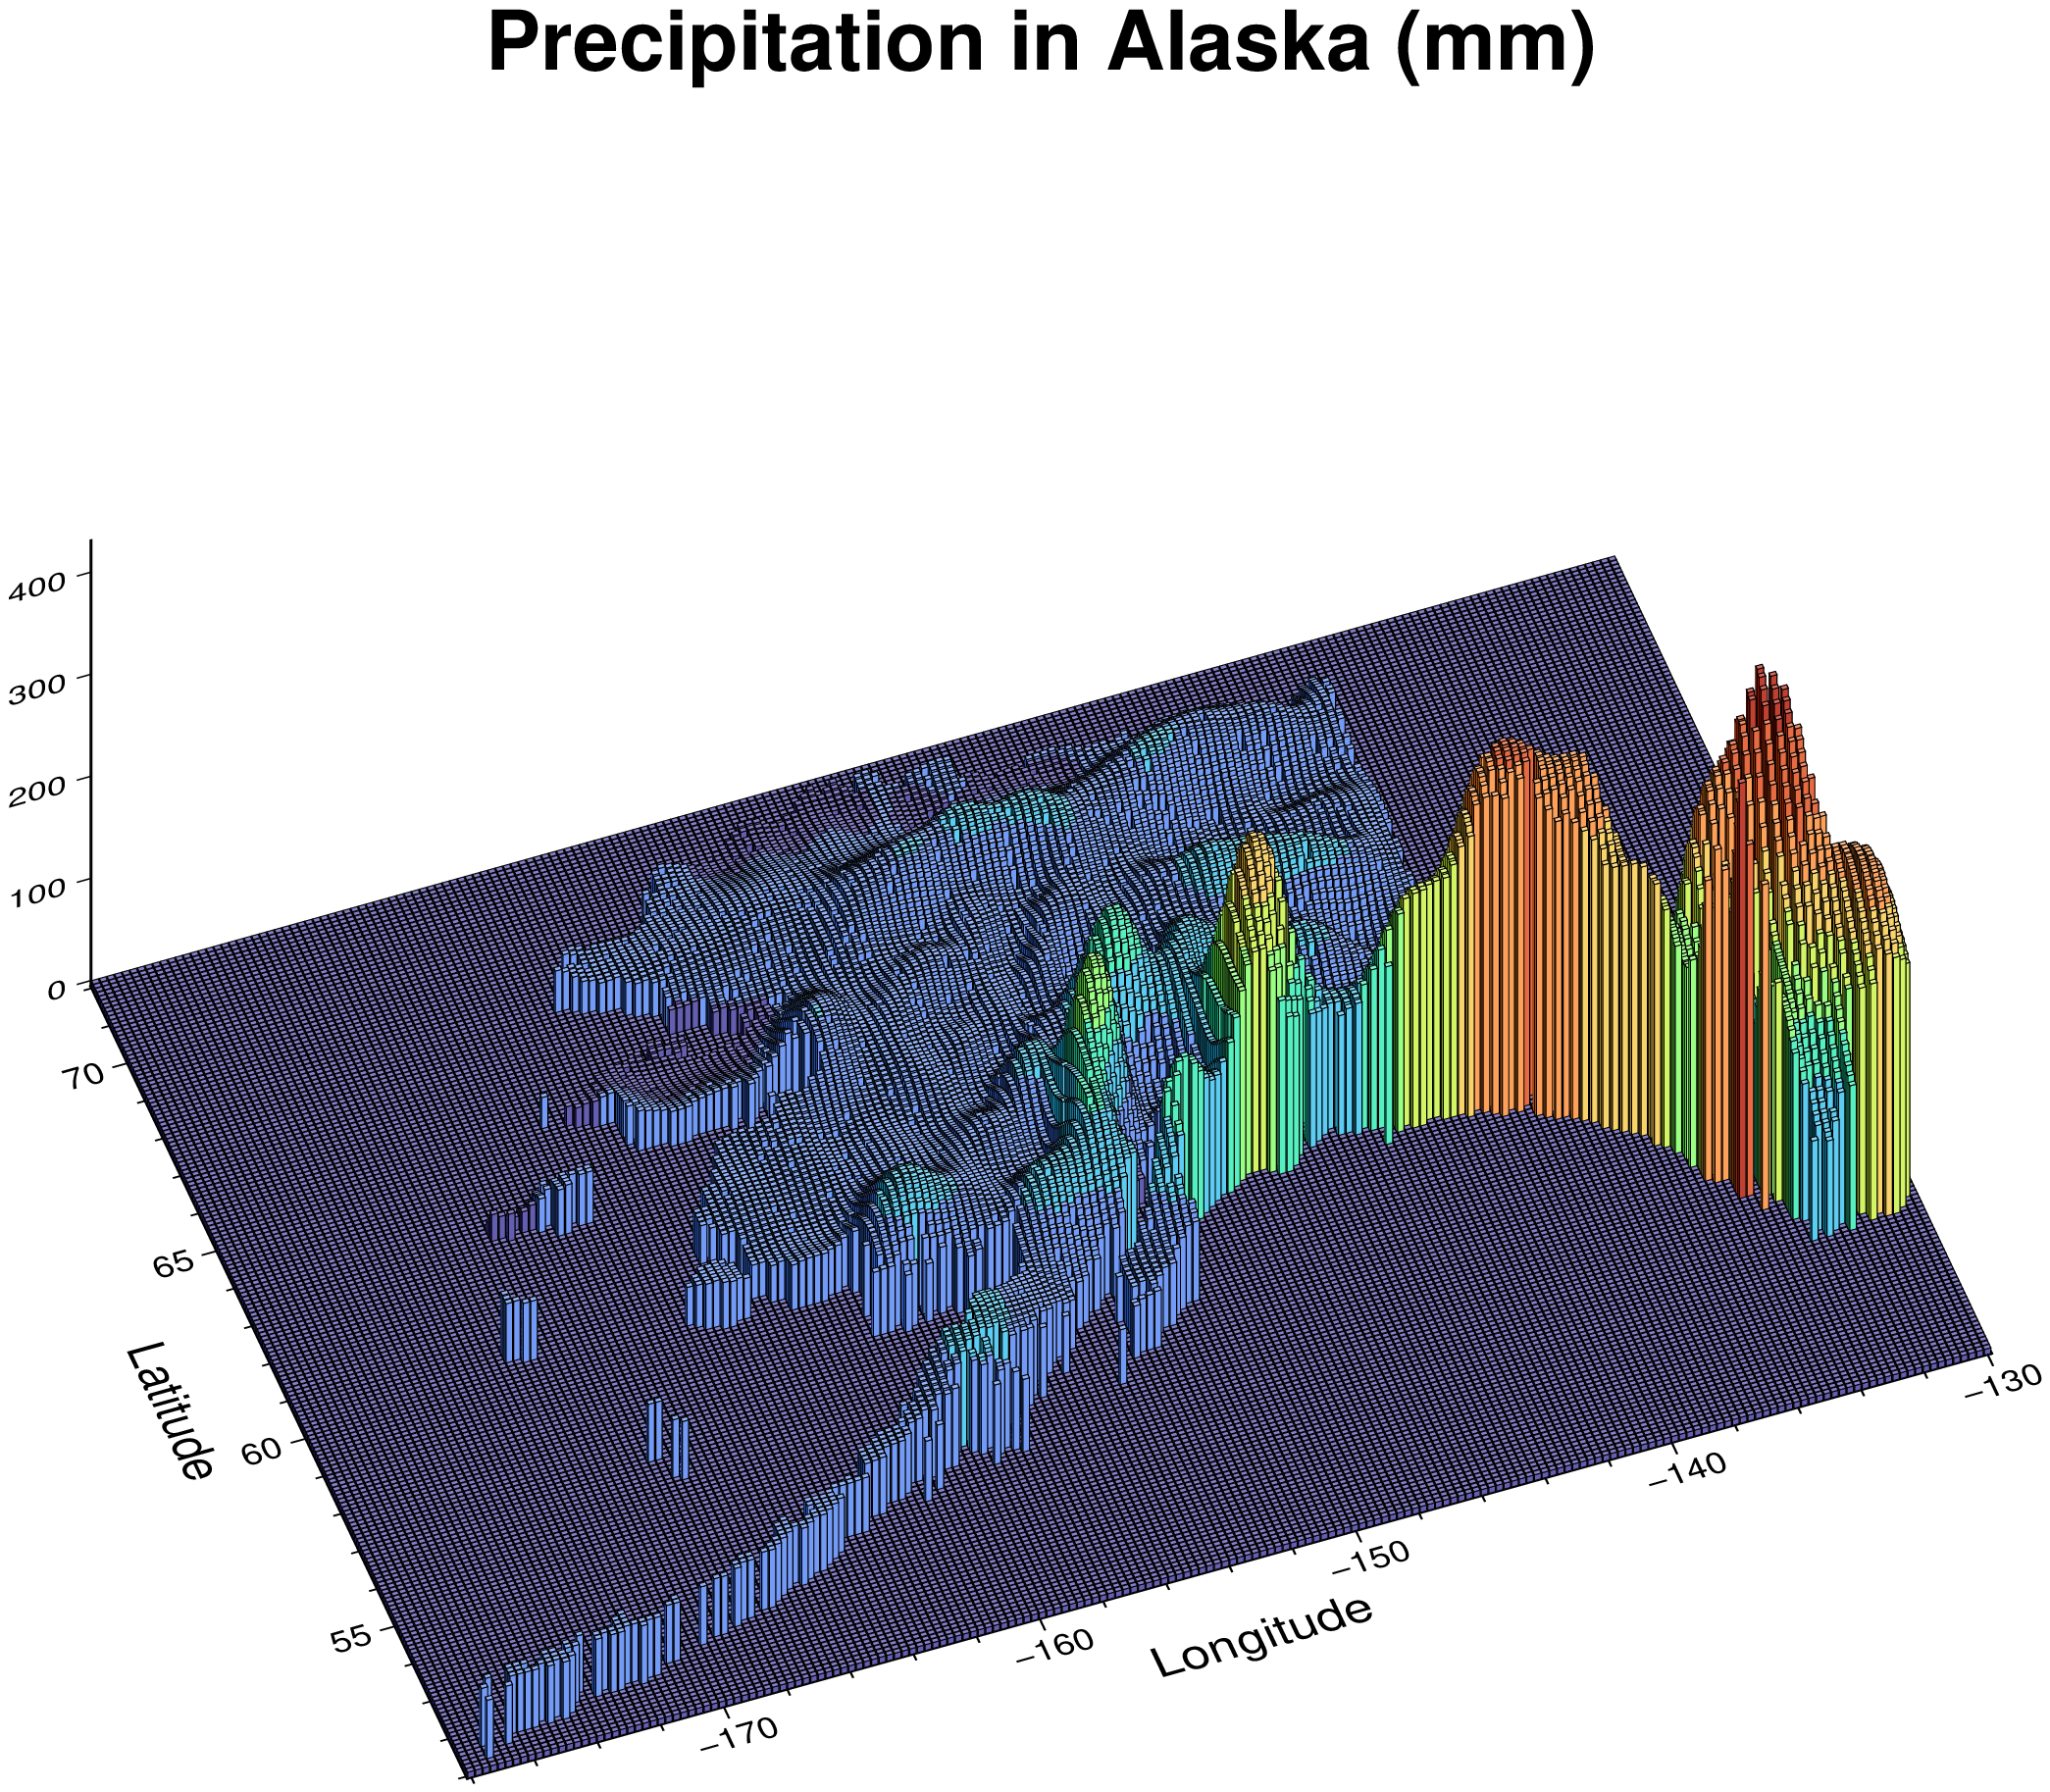

In [145]:
grid = GMT.mat2grid(mat, x=lon_edges, y=lat_edges)
cmap = GMT.grd2cpt(grid);  # Compute a colormap with the grid's data range

# Plotting function to make a 3D bar graph
GMT.bar3(grid, lw=:thinnest, color=cmap, fmt=:png, show=true, view=(200,50),
    xlabel="Longitude", ylabel="Latitude", title="Precipitation in Alaska (mm)")

Congratulations, you have fit a surface to the dataset! In your resulting contour graph, you should be able to notice 2-4 peaks which should appear in similar areas in your initial bar graph. Also compare with the graph in the PDF which is the regression fit performed by the team who published the dataset. You may notice that your fit seems a little bumpier than their fit, but that is okay. They use a slightly different technique for data interpolation and smoothing known as Thin Plate Splines: https://en.wikipedia.org/wiki/Thin_plate_spline . If you follow the link, you’ll notice though that there is a relation to the radial basis functions that we used ourselves! 

# Don't forget to hit the submit button once you have completed this part as well. Remember, you can submit as many times as you want. We grade the last submission